<h1><center>Time-series forecasting with deep learning & LSTM autoencoders</center></h1>

* The purpose of this work is to show one way time-series data can be effiently encoded to lower dimensions, to be used into non time-series models.
* Here I'll encode a time-series of size 12 (12 months) to a single value and use it on a MLP deep learning model, instead of using the time-series on a LSTM model that could be the regular approach.
* The first part of the data preparation is from my other kernel [Model stacking, feature engineering and EDA](https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda).
* This work was inspired by this Machinelearningmastery post [A Gentle Introduction to LSTM Autoencoders](https://machinelearningmastery.com/lstm-autoencoders/), make sure to check out.

<h2><center>Predict future sales</center></h2>

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

#### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


### Loading data

In [2]:
test = pd.read_csv('../input/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../input/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

### Join data sets

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Let's take a look at the raw data

In [4]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [5]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Time period of the dataset

In [7]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


I'm leaving only the "shop_id" and "item_id" that exist in the test set to have more accurate results.

In [8]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

### Data preprocessing
* I'm dropping all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
* We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
* Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [9]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,nan,nan,nan


In [10]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


### Time-series processing
* As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
* This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan"). 

In [11]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,2,2,0,2,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair.

In [12]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


#### Dropping identifier columns as we don't need them anymore.

In [13]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

### Train and validation sets.

In [14]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [15]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


### Reshape data.
* Time-series shape **(data points, time-steps, features)**.

In [16]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))
print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


#### First let's begin with how a regular RNN time-series approach could be.

### Regular LSTM model.

In [17]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.001

lstm_model = Sequential()
lstm_model.add(LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(LSTM(1, activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)
plot_model(lstm_model, show_shapes=True, to_file='regular_lstm.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 10)            480       
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [18]:
lstm_history = lstm_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, validation_data=(X_valid, Y_valid), verbose=2)

Train on 200327 samples, validate on 22259 samples
Epoch 1/20
 - 128s - loss: 1.2941 - val_loss: 1.1843
Epoch 2/20
 - 124s - loss: 1.1748 - val_loss: 1.1524
Epoch 3/20
 - 124s - loss: 1.1710 - val_loss: 1.1415
Epoch 4/20
 - 124s - loss: 1.1649 - val_loss: 1.1420
Epoch 5/20
 - 124s - loss: 1.1644 - val_loss: 1.1351
Epoch 6/20
 - 124s - loss: 1.1624 - val_loss: 1.1554
Epoch 7/20
 - 124s - loss: 1.1618 - val_loss: 1.1362
Epoch 8/20
 - 124s - loss: 1.1612 - val_loss: 1.1345
Epoch 9/20
 - 124s - loss: 1.1595 - val_loss: 1.1398
Epoch 10/20
 - 124s - loss: 1.1571 - val_loss: 1.1354
Epoch 11/20
 - 124s - loss: 1.1583 - val_loss: 1.1530
Epoch 12/20
 - 124s - loss: 1.1581 - val_loss: 1.1359
Epoch 13/20
 - 124s - loss: 1.1578 - val_loss: 1.1445
Epoch 14/20
 - 123s - loss: 1.1560 - val_loss: 1.1359
Epoch 15/20
 - 124s - loss: 1.1571 - val_loss: 1.1368
Epoch 16/20
 - 124s - loss: 1.1565 - val_loss: 1.1597
Epoch 17/20
 - 124s - loss: 1.1555 - val_loss: 1.1350
Epoch 18/20
 - 124s - loss: 1.1543 - val

### Autoencoder
* Now we will build an autoencoder to learn how to reconstruct the input, this way it internally learns the best way to represent the input in lower dimensions.
* The reconstruct model is composed of an encoder and a decoder, the encoder is responsible for learning how to represent the input into lower dimensions and the decoder learns how to rebuild the smaller representations into the input again.
* Here is a structural representations of an autoencoder:
 <img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Predict%20Future%20Sales/Autoencoder_structure.png" width="400">
* After the models is trained we can keep only the encoder part and we'll have a model that is able to do what we want.

### LSTM Autoencoder.

In [19]:
encoder_decoder = Sequential()
encoder_decoder.add(LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(1, activation='relu'))
encoder_decoder.add(RepeatVector(serie_size))
encoder_decoder.add(LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_6 (LSTM)                (None, 1)                 32        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 1)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)             13        
Total params: 1,845
Trainable params: 1,845
Non-trainable params: 0
_________________________________________________________________


In [20]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, epochs=epochs, batch_size=batch, verbose=2)

Epoch 1/20
 - 160s - loss: 1.0816
Epoch 2/20
 - 157s - loss: 1.0320
Epoch 3/20
 - 157s - loss: 0.9979
Epoch 4/20
 - 158s - loss: 0.9771
Epoch 5/20
 - 158s - loss: 0.9591
Epoch 6/20
 - 158s - loss: 0.9292
Epoch 7/20
 - 158s - loss: 0.9137
Epoch 8/20
 - 158s - loss: 0.8854
Epoch 9/20
 - 157s - loss: 0.8785
Epoch 10/20
 - 158s - loss: 0.8598
Epoch 11/20
 - 158s - loss: 0.9634
Epoch 12/20
 - 157s - loss: 1.0308
Epoch 13/20
 - 157s - loss: 1.0174
Epoch 14/20
 - 157s - loss: 1.0066
Epoch 15/20
 - 157s - loss: 0.9802
Epoch 16/20
 - 158s - loss: 1.0014
Epoch 17/20
 - 157s - loss: 1.0351
Epoch 18/20
 - 157s - loss: 0.9485
Epoch 19/20
 - 157s - loss: 1.0331
Epoch 20/20
 - 157s - loss: 1.0214


#### You should be aware that the better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.
#### Let's take a look at the layers of the encoder_decoder model:

In [21]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

#### About the autoencoder layers
#### LSTM
* This is just a regular LSTM layer, a layer that is able to receive sequence data and learn based on it nothing much to talk about.

#### RepeatVector layer
* Here is something we don't usually see, this layers basically repeats it's input "n" times, the reason to use it is because the last layers from the encoder part (the layer with one neuron) don't return sequences, so it does not outputs a sequenced data, this way we can't just add another LSTM layer after it, we need a way to turn this output into a sequence of the same time-steps of the model input, this is where "RepeatVector" layers comes in.
* Let's see what it outputs.

In [22]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]
 [0.8531282]]


As you can see this is just the same value repeated some times to match the same shape of the model input.

#### TimeDistributed layer
* This layer is more common, sometimes is used when you want to mix RNN layers with other kind of layers.
* We could output the model with another LSTM layer with one neuron and "return_sequences=True" parameter, but using a "TimeDistributed" layer wrapping a "Dense" layer we will have the same weights for each outputted time-step.

In [23]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

Time distributed output shape (1, 12, 1)
Time distributed output sample
[[0.2079489 ]
 [0.14144763]
 [0.19227591]
 [0.14422098]
 [0.04018045]
 [0.0919391 ]
 [0.14141658]
 [0.13461748]
 [0.16177025]
 [0.19957489]
 [0.24477303]
 [0.28889778]]


[Another good explanation about the used layers](https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/)

#### Defining the encoding model.
* What I want is to encode the whole series into a single value, so I need the output from the layer with a single neuron (in this case it's the third LSTM layer).
* I'll take only the encoding part of the model and define it as a new one.

In [24]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)
plot_model(encoder_decoder, show_shapes=True, to_file='encoder_decoder_reconstruct_lstm.png')
plot_model(encoder, show_shapes=True, to_file='encoder_lstm.png')

#### Now let's encode the train and validation time-series.

In [25]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (200327, 1)
Encoded time-series sample [0.8531281]


#### Add new encoded features to the train and validation sets.

In [26]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
207604,0,0,0,0,0,0,0,0,0,0,0,0,0.85,0
45150,0,0,0,0,0,0,0,0,0,0,0,0,0.85,0
143433,0,0,4,2,1,2,2,1,0,0,0,1,1.50,1
202144,0,0,0,0,0,0,0,0,0,0,0,0,0.85,0
136088,0,0,0,0,0,0,0,1,0,0,1,0,0.85,1
121675,0,0,0,0,0,1,0,0,0,0,0,0,0.89,0
185281,0,0,0,0,0,0,0,0,0,0,0,0,0.85,1
70087,0,0,0,0,0,0,0,0,3,0,1,3,0.85,0
105249,0,0,0,0,0,0,0,0,0,0,0,0,0.85,0
183257,0,0,0,0,0,3,0,1,0,0,0,1,0.98,0


#### Now we can use the new encoded feature that is a representation of the whole time-series and train a "less complex" model that does not receives sequenced data as input.

### MLP with LSTM encoded feature
* For the MLP model I'm only using the current month "item_count" and the encoded time-series feature from our LSTM encoder model, the idea is that we won't need the whole series because we already have a column that represents the whole series into a single value (it's like a dimensionality reduction).

In [27]:
last_month = serie_size - 1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_valid_encoded = valid['label']
valid.drop('label', axis=1, inplace=True)
X_valid_encoded = valid[[last_month, 'encoded']]

print("Train set", X_train_encoded.shape)
print("Validation set", X_valid_encoded.shape)

Train set (200327, 2)
Validation set (22259, 2)


In [28]:
X_train_encoded.head()

,11,encoded
207604,0,0.85
45150,0,0.85
143433,1,1.50
202144,0,0.85
136088,0,0.85


In [29]:
mlp_model = Sequential()
mlp_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dense(1))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)
plot_model(mlp_model, show_shapes=True, to_file='mlp.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [30]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)

Train on 200327 samples, validate on 22259 samples
Epoch 1/20
 - 6s - loss: 1.3098 - val_loss: 1.1999
Epoch 2/20
 - 6s - loss: 1.2280 - val_loss: 1.1976
Epoch 3/20
 - 6s - loss: 1.2284 - val_loss: 1.1963
Epoch 4/20
 - 6s - loss: 1.2266 - val_loss: 1.1980
Epoch 5/20
 - 6s - loss: 1.2262 - val_loss: 1.1951
Epoch 6/20
 - 6s - loss: 1.2249 - val_loss: 1.1977
Epoch 7/20
 - 6s - loss: 1.2250 - val_loss: 1.1899
Epoch 8/20
 - 6s - loss: 1.2246 - val_loss: 1.1948
Epoch 9/20
 - 6s - loss: 1.2242 - val_loss: 1.1956
Epoch 10/20
 - 6s - loss: 1.2232 - val_loss: 1.1985
Epoch 11/20
 - 6s - loss: 1.2234 - val_loss: 1.1936
Epoch 12/20
 - 6s - loss: 1.2226 - val_loss: 1.1970
Epoch 13/20
 - 6s - loss: 1.2222 - val_loss: 1.1963
Epoch 14/20
 - 6s - loss: 1.2213 - val_loss: 1.1950
Epoch 15/20
 - 6s - loss: 1.2213 - val_loss: 1.1935
Epoch 16/20
 - 6s - loss: 1.2199 - val_loss: 1.1898
Epoch 17/20
 - 6s - loss: 1.2188 - val_loss: 1.1961
Epoch 18/20
 - 6s - loss: 1.2191 - val_loss: 1.1889
Epoch 19/20
 - 6s - lo

### Comparing models
* As you can see I tried to build both models with a similar topology (type/number of layers and neurons), so it could make more sense to compare them.
* The results are pretty close, also they may change a bit depending on the random initialization of the networks weights, so I would say they are very similar in terms of performance.

#### Model training

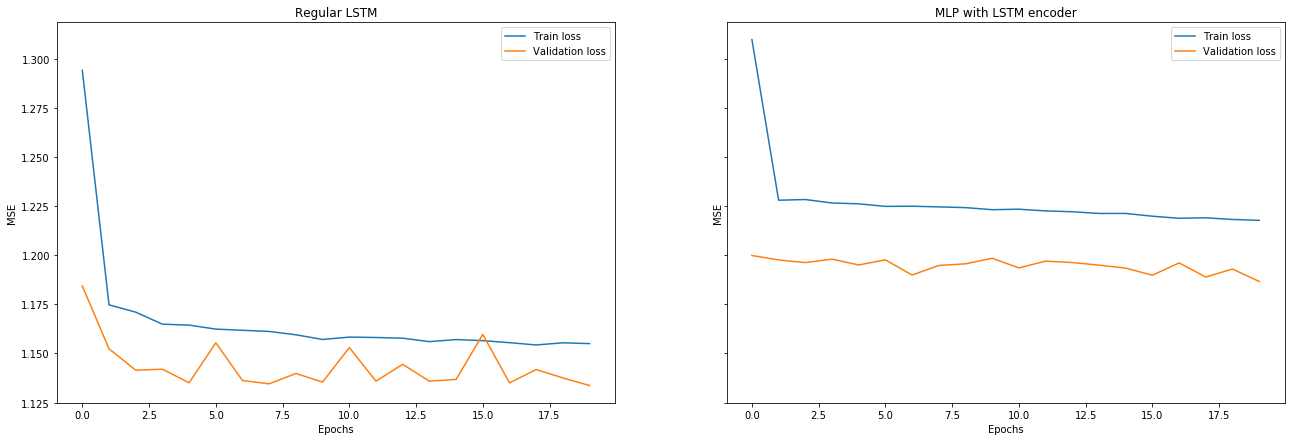

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(mlp_history.history['loss'], label='Train loss')
ax2.plot(mlp_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('MLP with LSTM encoder')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

plt.show()

#### Regular LSTM on train and validation.

In [32]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 1.0723959926810707
Validation rmse: 1.064751291525756


#### MLP with LSTM encoder on train and validation.

In [33]:
mlp_train_pred2 = mlp_model.predict(X_train_encoded.values)
mlp_val_pred2 = mlp_model.predict(X_valid_encoded.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_encoded, mlp_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_encoded, mlp_val_pred2)))

Train rmse: 1.1029331202327708
Validation rmse: 1.0893327160931334


### Built test set
#### Since we have two models I'll build test sets to apply on both of them.

In [34]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Regular LSTM model test predictions
* For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [35]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Reshape data.
* Time-series shape **(data points, time-steps, features)**.

In [36]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


#### Making predictions.

In [37]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

 ### MLP with LSTM encoded feature test predictions
* For the MLP model with the encoded features I'm only using the current month "item_count" and the encoded time-series feature from our LSTM encoder model.

#### Encoding the time-series

In [38]:
test_encoded = encoder.predict(X_test_reshaped)

#### Add encoded features to the test set.

In [39]:
X_test['encoded'] = test_encoded
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33,encoded
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,1.15
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00,0.95
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.85
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85


In [40]:
X_test_encoded = X_test[[33, 'encoded']]
print("Train set", X_test_encoded.shape)
X_test_encoded.head()

Train set (214200, 2)


,33,encoded
0,0.00,1.15
1,0.00,0.85
2,1.00,0.95
3,0.00,0.85
4,0.00,0.85


#### Making predictions.

In [41]:
mlp_test_pred = mlp_model.predict(X_test_encoded)

#### Predictions from the regular LSTM model.

In [42]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
lstm_prediction.to_csv('lstm_submission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.58
1,1,0.49
2,2,0.86
3,3,0.18
4,4,0.49
5,5,0.39
6,6,1.08
7,7,0.17
8,8,1.31
9,9,0.49


#### Predictions from the MLP model with LSTM encodded feature .

In [43]:
mlp_prediction = pd.DataFrame(test['ID'], columns=['ID'])
mlp_prediction['item_cnt_month'] = mlp_test_pred.clip(0., 20.)
mlp_prediction.to_csv('mlp_submission.csv', index=False)
mlp_prediction.head(10)

,ID,item_cnt_month
0,0,0.22
1,1,0.27
2,2,0.35
3,3,0.27
4,4,0.27
5,5,0.42
6,6,0.79
7,7,0.24
8,8,0.49
9,9,0.27


Just a disclaimer, you absolutely can get better results on any of the used models,  I did not spent too much time tuning the models hyper parameters, as this is just for demonstration purpose, so if you want to give the code a try, you should surely tune a little more, if you get better results or any good insight about the models or architecture please let me know.